## Library Imports

In [2]:
# standard library imports
import os
import pytz
import time
import json
import warnings
import itertools
from tqdm import tqdm
from typing import Tuple
from pathlib import Path
import multiprocessing as mp
from datetime import datetime, timedelta

# Third Party Import
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from scipy.signal import savgol_filter

# Alpaca Data Imports
from alpaca.data.requests import CryptoBarsRequest
from alpaca.data.timeframe import TimeFrame, TimeFrameUnit
from alpaca.data.historical import CryptoHistoricalDataClient

In [3]:
warnings.filterwarnings('ignore')
fig_path = Path(Path.cwd(), "data/optimization/mean_reversion_algo_opt-2/figures")
fig_path.mkdir(parents=True, exist_ok=True)

json_path = Path(Path.cwd(), "data/optimization/mean_reversion_algo_opt-2/json")
json_path.mkdir(parents=True, exist_ok=True)

## Starting Parameters

### Parameters to optimize

In [4]:
RESOLUTION = 10  # minute
FIRST_MOV_AVG_DAY = 0.1  # days
SECOND_MOV_AVG_DAY = 3  # days
DERIV_CUTOFF = 0.15
WIN_LENGTH = 15 # period
DERIVATIVE = 1

### Parameter Ranges to Test

In [5]:
resolution_range = [30, 60, 90, 120]
first_mov_avg_range = [0.1, 0.2, 0.5]
second_mov_avg_range = [4, 5, 6, 8]
deriv_cutoff_range = [0.25, 0.35, 0.45]
win_length_range = [5, 15, 30]

In [6]:
resolution_range = [30, 60]
first_mov_avg_range = [0.1]
second_mov_avg_range = [4]
deriv_cutoff_range = [0.25]
win_length_range = [5]

### Constant Parameters

In [7]:
INVESTMENT = 10_000  # dollars
initial_investment = INVESTMENT
TICKER_SYMBOL = "BTC/USD"
DATA_FOLDER = "mean_reversion_algo_opt-1"
TIME_LENGTH = 90 # days
GRAPH_LENGTH = 5 # days
has_position = False
initial_time = datetime.now(pytz.utc) - timedelta(days=TIME_LENGTH)
start_time = initial_time + timedelta(days=GRAPH_LENGTH)
step_time = start_time + timedelta(minutes=10)
end_time = datetime.now(pytz.utc)
time_steps = float(np.floor((end_time- start_time)/timedelta(minutes=RESOLUTION)))

parameters_dict = {}
orders_dict = {}

In [8]:
def reset_order():
    curr_order = {
        "Buy Datetime": "",
        "Buy Price": "",
        "Deriv at Purchase": "",
        "Sell Datetime": "",
        "Sell Price": "",
        "Percent Change": "",
        "Total Profit": "",
        "Deriv at Sell": "",
        "Just Sold": False,
        "Has Position": False,
        "Above Average": 0,
        "CumSum Profit": 0,
    }
    return curr_order

## Optimization Algorithm

### Function to get data from Alpaca API

In [9]:
def get_crypto_data(
    resolution,
    start_time,
    end_time,
    symbol,
) -> Tuple[pd.DataFrame, float]:
    """
    This function gets crypto data for the user based on the
    resolution, time lenght and crypto symbol specified

    Returns:
        Tuple[pd.DataFrame, float]: returns a tuple of a dataframe
        with crypto bar data and the current price of the asset
    """
    if resolution < 60:
        time_frame = TimeFrame(resolution, TimeFrameUnit("Min"))
    else:
        time_frame = TimeFrame(int(resolution/60), TimeFrameUnit("Hour"))

    # No keys required for crypto data
    client = CryptoHistoricalDataClient()

    # Creating request object
    request_params = CryptoBarsRequest(
        symbol_or_symbols=symbol,
        timeframe=time_frame,
        start=start_time,
        end=end_time,
    )

    # Retrieve daily bars for Bitcoin in a DataFrame and printing it
    bars = client.get_crypto_bars(request_params)
    # Convert to dataframe
    data = bars.df.reset_index()

    return data

def calculate_columns(data, resolution, first_mov_avg, second_mov_avg, win_length, deriv):
    """
    Optimized function to compute moving averages and derivatives on crypto data.
    """
    factor = int(60 / resolution) * 24  # Converts moving averages into minutes
    first_mov_avg_res = first_mov_avg * factor
    second_mov_avg_res = second_mov_avg * factor

    # close_prices = data["close"].values  # Convert to NumPy for speed

    # Compute moving averages using a faster method
    data["Moving Avg (First)"] = data["close"].rolling(int(first_mov_avg_res)).mean()
    # data["Moving Avg (First) STD"] = bn.move_std(close_prices, window=int(first_mov_avg_res), min_count=1)
    data["Moving Avg (Second)"] = data["close"].rolling(int(second_mov_avg_res)).mean()
    # data["Moving Avg (Second) STD"] = bn.move_std(close_prices, window=int(second_mov_avg_res), min_count=1)

    # Apply Savitzky-Golay filter once and reuse results
    first_ma_filtered = savgol_filter(data["Moving Avg (First)"].values, win_length, 2)
    second_ma_filtered = savgol_filter(data["Moving Avg (Second)"].values, win_length, 2)

    data["Moving Avg (First) Deriv"] = savgol_filter(first_ma_filtered, win_length, 2, deriv=deriv)
    data["Moving Avg (First) Deriv2"] = savgol_filter(first_ma_filtered, win_length, 2, deriv=2)

    data["Moving Avg (Second) Deriv"] = savgol_filter(second_ma_filtered, win_length, 2, deriv=deriv)
    data["Moving Avg (Second) Deriv2"] = savgol_filter(second_ma_filtered, win_length, 2, deriv=2)

    return data, data.iloc[-1]  # Return last row directly



In [10]:
def mean_reversion_crypto_algo(
    curr_row, curr_order, deriv_cutoff, investment, sec_der_strat=False
):
    """_summary_"""
    if curr_order["Just Sold"]:
        curr_order["Just Sold"] = False

    # In case script is interuppted or data is lost check to see if
    # the last order was a buy or sell to determine if holding a current
    # position or not
    if sec_der_strat:
        if (
            (curr_row["Moving Avg (First)"] > curr_row["Moving Avg (Second)"])
            and not curr_order["Has Position"]
            and (curr_row["Moving Avg (First) Deriv"] > 0)
            and (curr_row["Moving Avg (First) Deriv2"] > 0)
        ):
            curr_order["Has Position"] = True

            curr_order["Buy Datetime"] = curr_row["timestamp"]
            curr_order["Buy Price"] = curr_row["close"]
            curr_order["Deriv at Purchase"] = curr_row["Moving Avg (First) Deriv"]
    else:
        if (
            (curr_row["Moving Avg (First)"] > curr_row["Moving Avg (Second)"])
            and not curr_order["Has Position"]
            and (curr_row["Moving Avg (First) Deriv"] > 0)
        ):
            curr_order["Has Position"] = True

            curr_order["Buy Datetime"] = curr_row["timestamp"]
            curr_order["Buy Price"] = curr_row["close"]
            curr_order["Deriv at Purchase"] = curr_row["Moving Avg (First) Deriv"]

    if curr_order["Has Position"]:
        if (
            curr_row["Moving Avg (First) Deriv"]
            < curr_order["Deriv at Purchase"] * deriv_cutoff
        ):
            # Sell the current position

            curr_order["Sell Datetime"] = curr_row["timestamp"]
            curr_order["Sell Price"] = curr_row["close"]
            curr_order["Percent Change"] = (
                100
                * (curr_order["Sell Price"] - curr_order["Buy Price"])
                / curr_order["Buy Price"]
            )
            curr_order["Total Profit"] = curr_order["Percent Change"] * investment / 100
            curr_order["Deriv at Sell"] = curr_row["Moving Avg (First) Deriv"]
            curr_order["Just Sold"] = True

            investment += curr_order["Total Profit"]
            curr_order["CumSum Profit"] += curr_order["Total Profit"]
            curr_order["Has Position"] = False

    return curr_order, investment

## Optimization Loop

### Optimization Function

In [11]:
def optimization_loop(args):
    data, res, fma, sma, win, der = args
    orders_dict = {}
    curr_order = reset_order()
    initial_investment = 10_000

    time_steps_ = int((end_time - start_time) / timedelta(minutes=res))  # Precompute integer

    for step in range(time_steps_):
        # Avoid copying data in every iteration
        curr_data_ = data.iloc[: -time_steps_ + step, :]

        # Compute only what's necessary
        _, curr_row_ = calculate_columns(
            data=curr_data_,
            resolution=res,
            first_mov_avg=fma,
            second_mov_avg=sma,
            win_length=win,
            deriv=1  # If deriv is always 1, pass it as a default arg
        )

        curr_order, initial_investment = mean_reversion_crypto_algo(
            curr_row=curr_row_,
            curr_order=curr_order,
            deriv_cutoff=der,
            investment=initial_investment,
        )

        if curr_order["Just Sold"]:
            orders_dict[step] = curr_order.copy()  # Could use a list instead for speed

    # Avoid global variable lookups
    # profit = initial_investment - 10_000 

    return {
        "Arguments": (res, fma, sma, win, der),  # Use tuple instead of list (immutable)
        "Profit": curr_order["CumSum Profit"]
    }


    # try:
    #     if profit > best_params["Profit"]:
    #         best_params["Resolution"] = res
    #         best_params["First Moving Average Day"] = fma
    #         best_params["Second Moving Average Day"] = sma
    #         best_params["Derivative Cutoff"] = der
    #         best_params["Savgol Window Length"] = win
    #         # best_params["Derivative"] = deriv
    #         best_params["Profit"] = profit
    #         best_dict = orders_dict.copy()

    # except IndexError:
    #     pass

# Function to retrieve the crypto data (should be outside multiprocessing)
def get_data_for_resolution(res):
    return get_crypto_data(
        resolution=res,
        start_time=initial_time,
        end_time=end_time,
        symbol=TICKER_SYMBOL,
    )

In [12]:
# all_results = {}  # Store final results

# print("Starting Optimization loop...")
# for res in resolution_range:
#     data = get_data_for_resolution(res)  # Retrieve once per resolution

#     # Generate all parameter combinations for the current resolution
#     combinations = list(itertools.product(
#         [data], [res], first_mov_avg_range, second_mov_avg_range, win_length_range, deriv_cutoff_range
#     ))

#     with tqdm(total=len(combinations), desc=f"Processing resolution {res}", unit="task") as pbar:
#         for idx, combo in enumerate(combinations):
#             result = optimization_loop(combo)
#             all_results[idx] = result
#             pbar.update(1)  # Update progress bar

### Load Params if needed

In [13]:
best_params = {
    "Resolution": RESOLUTION,
    "First Moving Average Day": FIRST_MOV_AVG_DAY,
    "Second Moving Average Day": SECOND_MOV_AVG_DAY,
    "Derivative Cutoff": DERIV_CUTOFF,
    "Savgol Window Length": WIN_LENGTH,
    "Derivative": DERIVATIVE,
    "Profit Factor": 0,
    "Initial Investment": INVESTMENT,
}

In [14]:
with open(Path(json_path, "2025-03-29_0122-90_day_optimization_parameters"), 'r') as file:
    best_params = json.load(file)

best_params

FileNotFoundError: [Errno 2] No such file or directory: 'c:\\Users\\zhatz\\Documents\\GitHub\\Stupid-Metrics\\data\\optimization\\mean_reversion_algo_opt-2\\json\\2025-03-29_0122-90_day_optimization_parameters'

In [ ]:
best_factor = 0
for i in data:
    if np.abs(i["Profit Factor"]) > best_factor:
        best_factor = np.abs(i["Profit Factor"])

## Best Loop From Optimization

In [16]:
data = get_crypto_data(
    resolution=best_params["Resolution"],
    start_time=initial_time,
    end_time=end_time,
    symbol=TICKER_SYMBOL,
)

len(data)

12912

In [20]:
len(data) - (GRAPH_LENGTH * 24 * 60/ best_params["Resolution"])

12192.0

In [19]:
float(np.floor((end_time - start_time)/timedelta(minutes=best_params["Resolution"])))

12240.0

In [ ]:
optimized_orders_dict = {}
datasets = {}
curr_order = reset_order()
initial_investment = 10_000

data = get_crypto_data(
    resolution=best_params["Resolution"],
    start_time=initial_time,
    end_time=end_time,
    symbol=TICKER_SYMBOL,
)
time_steps_ = float(np.floor((end_time - start_time)/timedelta(minutes=best_params["Resolution"])))
time_steps_ = len(data) best_params["Resolution"] * GRAPH_LENGTH * 24 * 60
for step in range(int(time_steps_)):
    curr_data = data.copy().iloc[:-int(time_steps_)+step, :]
    
    _, curr_row = calculate_columns(
        data=curr_data,
        resolution=best_params["Resolution"],
        first_mov_avg=best_params["First Moving Average Day"],
        # first_mov_avg=1,
        second_mov_avg=best_params["Second Moving Average Day"],
        win_length=best_params["Savgol Window Length"],
        deriv=1
    )

    curr_order, initial_investment = mean_reversion_crypto_algo(
        curr_row=curr_row,
        curr_order=curr_order,
        deriv_cutoff=best_params["Derivative Cutoff"],
        investment=initial_investment,
        sec_der_strat=False
    )

    if curr_order["Just Sold"]:
        optimized_orders_dict[step] = curr_order.copy()
        datasets[step] = curr_data.copy()

true_dataset = pd.concat(datasets, ignore_index=True)

In [ ]:
optimized_orders_dict = {}
datasets = {}
curr_order = reset_order()
initial_investment = 10_000

data = get_crypto_data(
    resolution=best_params["Resolution"],
    start_time=initial_time,
    end_time=end_time,
    symbol=TICKER_SYMBOL,
)
time_steps_ = float(np.floor((end_time - start_time)/timedelta(minutes=best_params["Resolution"])))
for step in range(int(time_steps_)):
    curr_data = data.copy().iloc[:-int(time_steps_)+step, :]
    
    _, curr_row = calculate_columns(
        data=curr_data,
        resolution=best_params["Resolution"],
        first_mov_avg=best_params["First Moving Average Day"],
        # first_mov_avg=1,
        second_mov_avg=best_params["Second Moving Average Day"],
        win_length=best_params["Savgol Window Length"],
        deriv=1
    )

    curr_order, initial_investment = mean_reversion_crypto_algo(
        curr_row=curr_row,
        curr_order=curr_order,
        deriv_cutoff=best_params["Derivative Cutoff"],
        investment=initial_investment,
        sec_der_strat=False
    )

    if curr_order["Just Sold"]:
        optimized_orders_dict[step] = curr_order.copy()
        datasets[step] = curr_data.copy()

true_dataset = pd.concat(datasets, ignore_index=True)

### Plot the Order Results

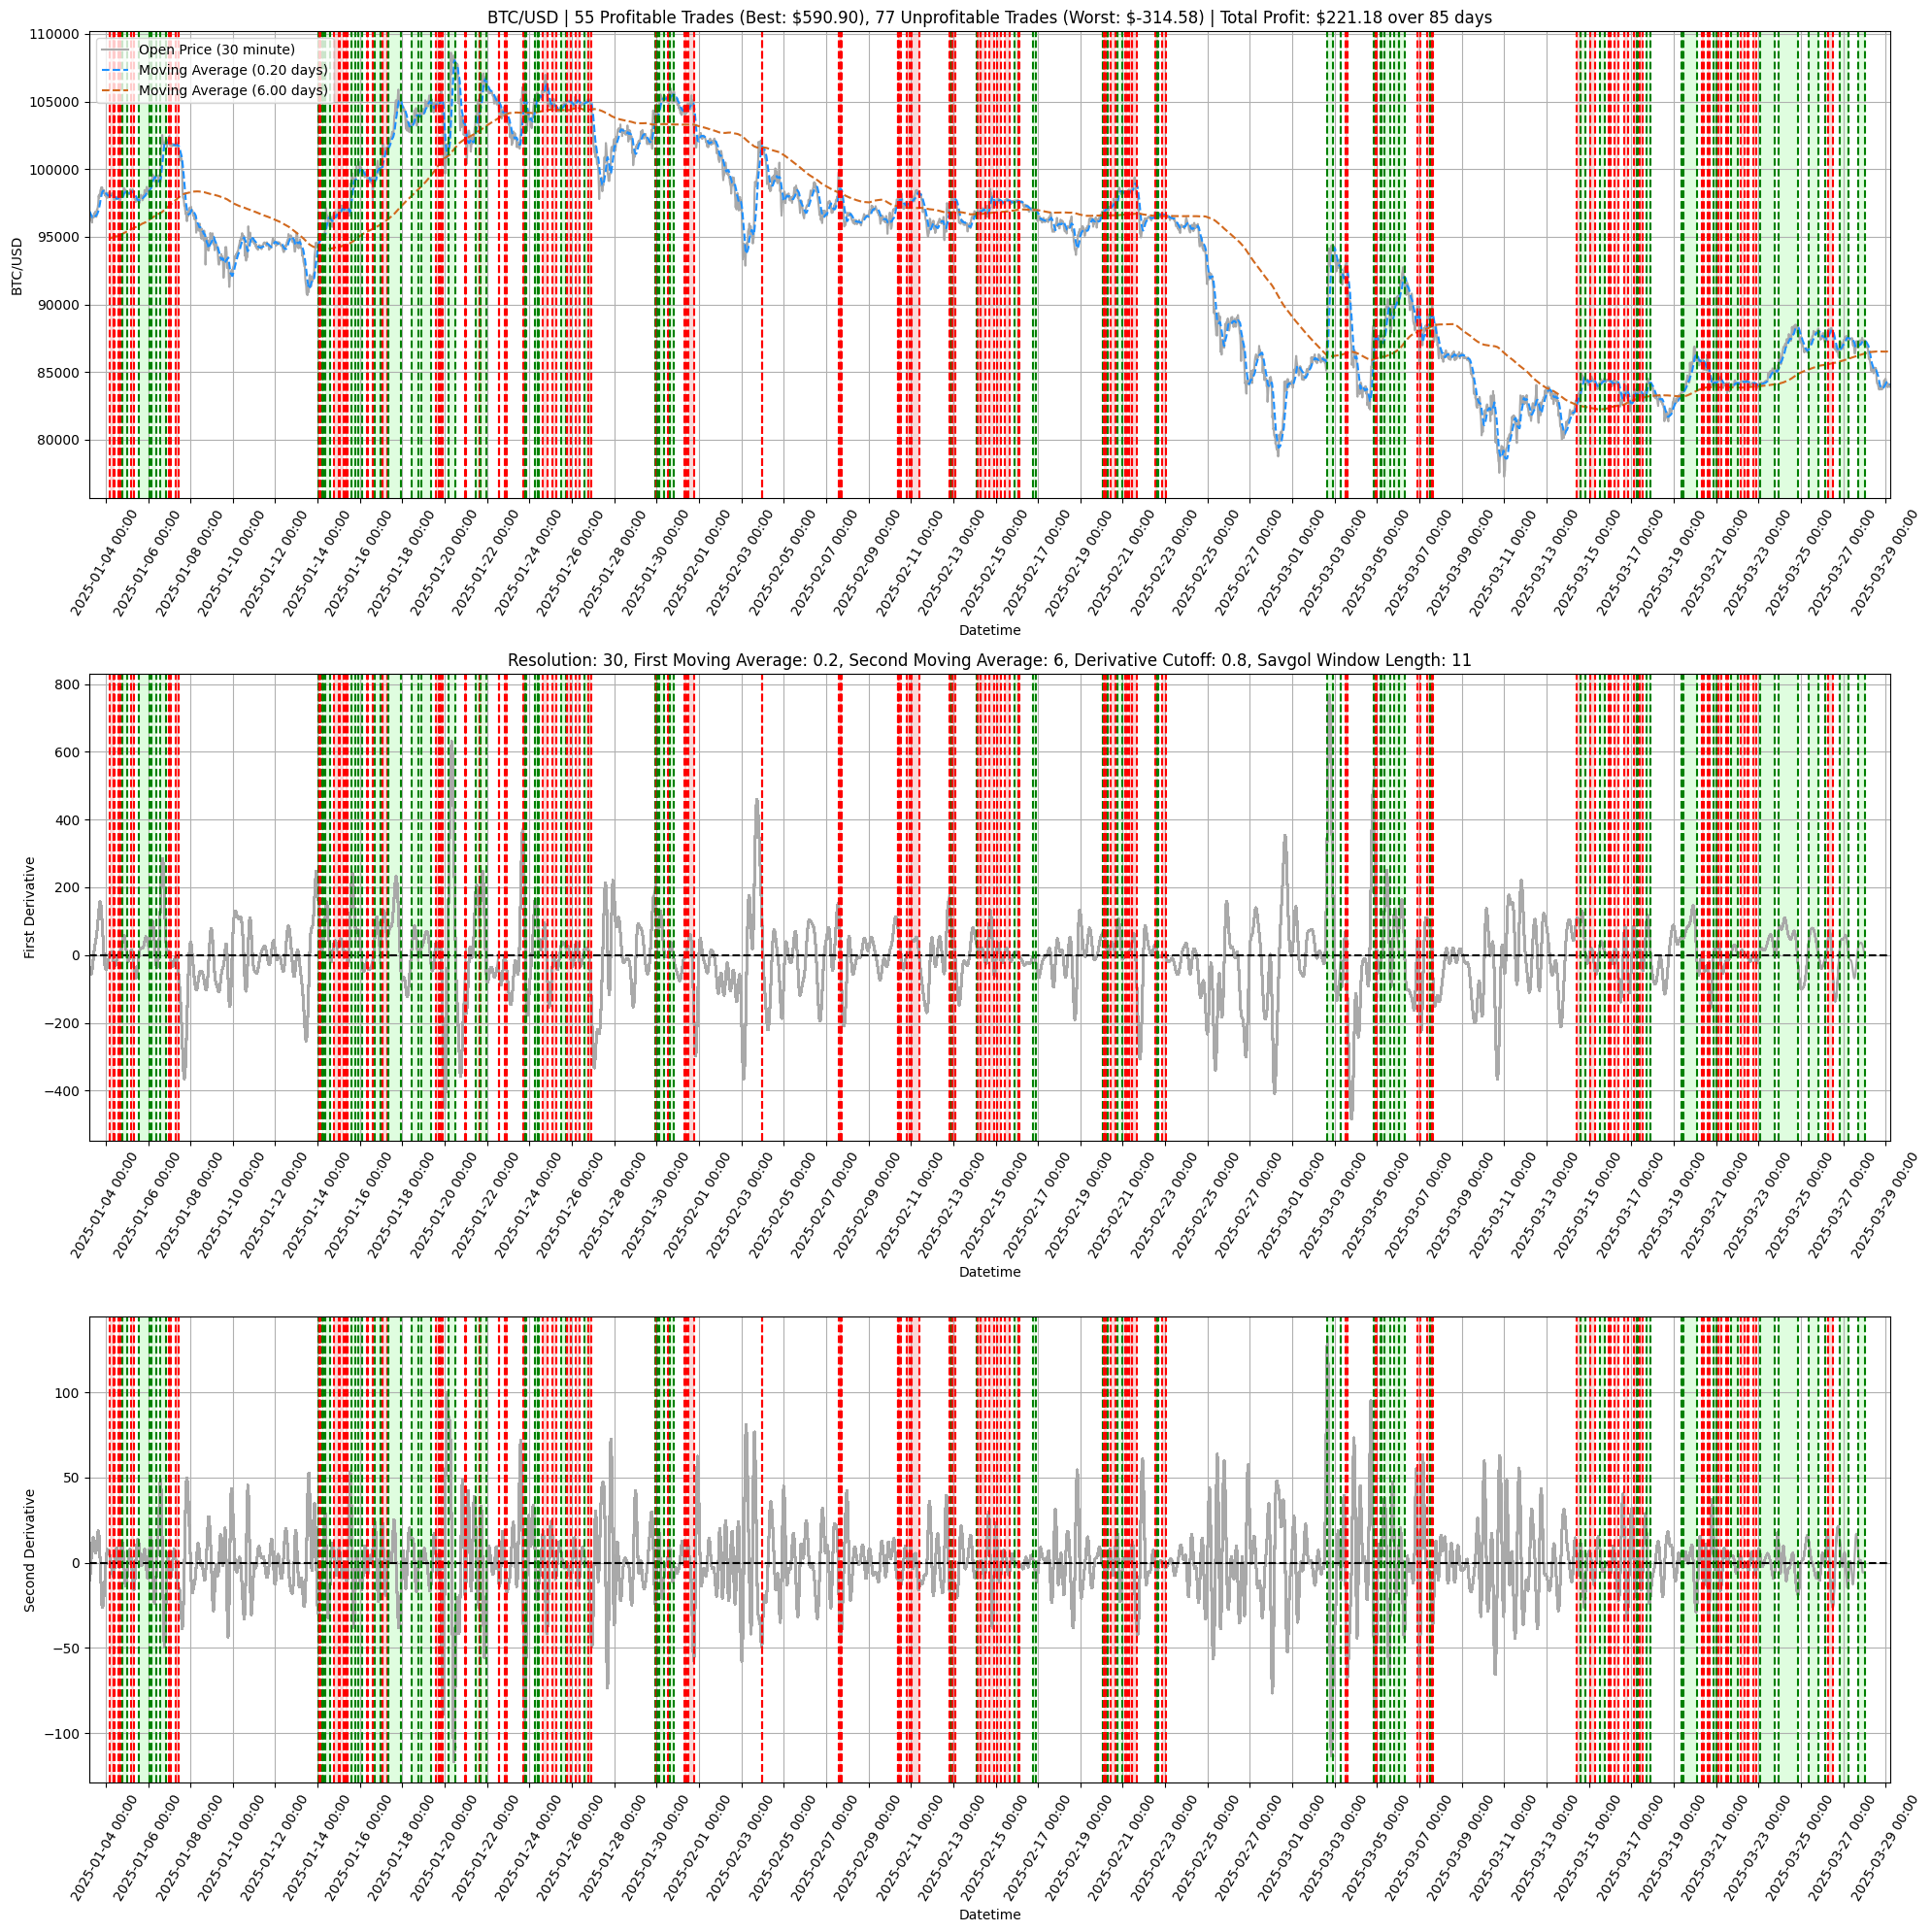

In [ ]:
fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(20, 20))

data, _ = calculate_columns(
    data=data,
    resolution=best_params["Resolution"],
    first_mov_avg=best_params["First Moving Average Day"],
    second_mov_avg=best_params['Second Moving Average Day'],
    win_length=best_params["Savgol Window Length"],
    deriv=1
)

sum_profit = 0
successful_trades = 0
best_trade = -np.inf

failed_trades = 0
worst_trade = np.inf

ax[0].plot(
    data["timestamp"],
    data["close"],
    c="darkgray",
    label=f"Open Price ({best_params['Resolution']} minute)",
)

ax[0].plot(
    data["timestamp"],
    data["Moving Avg (First)"],
    c="dodgerblue",
    linestyle="--",
    label=f"Moving Average ({best_params['First Moving Average Day']:0.2f} days)",
)

ax[0].plot(
    data["timestamp"],
    data["Moving Avg (Second)"],
    c="chocolate",
    linestyle="--",
    label=f"Moving Average ({best_params['Second Moving Average Day']:0.2f} days)",
)

ax[0].grid()
ax[0].legend()
ax[0].set_xlim(start_time, end_time)
ax[0].set_xlabel("Datetime")
ax[0].set_ylabel(f"{TICKER_SYMBOL}")


axis_interval = int(TIME_LENGTH/20) if TIME_LENGTH/20 > 1  else 1
ax[0].xaxis.set_major_locator(mdates.DayLocator(interval=axis_interval))
ax[0].tick_params(axis="x", labelrotation=60)


ax[1].plot(
    true_dataset["timestamp"],
    true_dataset["Moving Avg (First) Deriv"],
    c="darkgray",
    label=f"Moving Average ({best_params['First Moving Average Day']:0.2f} days)",
)
ax[1].axhline(0, linestyle="--", c="k")

ax[1].grid()
ax[1].set_xlim(start_time, end_time)
ax[1].set_xlabel("Datetime")
ax[1].set_ylabel("First Derivative")
ax[1].xaxis.set_major_locator(mdates.DayLocator(interval=axis_interval))
ax[1].tick_params(axis="x", labelrotation=60)

ax[2].plot(
    true_dataset["timestamp"],
    true_dataset["Moving Avg (First) Deriv2"],
    c="darkgray",
    label=f"Moving Average ({best_params['First Moving Average Day']:0.2f} days)",
)
ax[2].axhline(0, linestyle="--", c="k")

ax[2].grid()
ax[2].set_xlim(start_time, end_time)
ax[2].set_xlabel("Datetime")
ax[2].set_ylabel("Second Derivative")
ax[2].xaxis.set_major_locator(mdates.DayLocator(interval=axis_interval))
ax[2].tick_params(axis="x", labelrotation=60)

for key, true_dataset in optimized_orders_dict.items():
    try:
        if true_dataset["Total Profit"] >= 0:
            successful_trades += 1
            sum_profit += true_dataset["Total Profit"]
            if best_trade < true_dataset["Total Profit"]:
                best_trade = true_dataset["Total Profit"]

            ax[0].axvline(true_dataset["Buy Datetime"], linestyle="--", c="green")
            ax[1].axvline(true_dataset["Buy Datetime"], linestyle="--", c="green")
            ax[2].axvline(true_dataset["Buy Datetime"], linestyle="--", c="green")

            ax[0].axvline(true_dataset["Sell Datetime"], linestyle="--", c="green")
            ax[1].axvline(true_dataset["Sell Datetime"], linestyle="--", c="green")
            ax[2].axvline(true_dataset["Sell Datetime"], linestyle="--", c="green")\

            ax[0].axvspan(
                true_dataset["Buy Datetime"],
                true_dataset["Sell Datetime"],
                linestyle="--",
                facecolor="palegreen",
                alpha=0.3,
            )
            ax[1].axvspan(
                true_dataset["Buy Datetime"],
                true_dataset["Sell Datetime"],
                linestyle="--",
                facecolor="palegreen",
                alpha=0.3,
            )
            ax[2].axvspan(
                true_dataset["Buy Datetime"],
                true_dataset["Sell Datetime"],
                linestyle="--",
                facecolor="palegreen",
                alpha=0.3,
            )
        else:
            failed_trades += 1
            sum_profit += true_dataset["Total Profit"]
            if worst_trade > true_dataset["Total Profit"]:
                worst_trade = true_dataset["Total Profit"]

            ax[0].axvline(true_dataset["Buy Datetime"], linestyle="--", c="red")
            ax[1].axvline(true_dataset["Buy Datetime"], linestyle="--", c="red")
            ax[2].axvline(true_dataset["Buy Datetime"], linestyle="--", c="red")

            ax[0].axvline(true_dataset["Sell Datetime"], linestyle="--", c="red")
            ax[1].axvline(true_dataset["Sell Datetime"], linestyle="--", c="red")
            ax[2].axvline(true_dataset["Sell Datetime"], linestyle="--", c="red")

            ax[0].axvspan(
                true_dataset["Buy Datetime"],
                true_dataset["Sell Datetime"],
                linestyle="--",
                facecolor="lightcoral",
                alpha=0.3,
            )
            ax[1].axvspan(
                true_dataset["Buy Datetime"],
                true_dataset["Sell Datetime"],
                linestyle="--",
                facecolor="lightcoral",
                alpha=0.3,
            )
            ax[2].axvspan(
                true_dataset["Buy Datetime"],
                true_dataset["Sell Datetime"],
                linestyle="--",
                facecolor="lightcoral",
                alpha=0.3,
            )
    except KeyError:
        ax[0].axvline(true_dataset["Buy Datetime"], linestyle="--", c="green")
        ax[1].axvline(true_dataset["Buy Datetime"], linestyle="--", c="green")
        ax[2].axvline(true_dataset["Buy Datetime"], linestyle="--", c="green")

# Set x-axis to display hour ticks
hours = mdates.DayLocator(interval=2)  # Ticks every hour
h_fmt = mdates.DateFormatter('%Y-%m-%d %H:%M')  # Format as HH:MM

title = (
    f"{TICKER_SYMBOL} | {successful_trades} Profitable Trades (Best: ${best_trade:,.2f}), "
    f"{failed_trades} Unprofitable Trades (Worst: ${worst_trade:,.2f}) | "
    f"Total Profit: ${sum_profit:,.2f} over {TIME_LENGTH-GRAPH_LENGTH} days"
)

title_2 = (
    f"Resolution: {best_params['Resolution']}, First Moving Average: {best_params['First Moving Average Day']}, Second Moving Average: {best_params['Second Moving Average Day']}, "
    f"Derivative Cutoff: {best_params['Derivative Cutoff']}, Savgol Window Length: {best_params['Savgol Window Length']}"
)

{'Resolution': 10,
 'First Moving Average Day': 0.2,
 'Second Moving Average Day': 5,
 'Derivative Cutoff': 0.25,
 'Savgol Window Length': 5,
 'Derivative': 1,
 'Profit': np.float64(565.094483855095)}

ax[0].set_title(title)
ax[1].set_title(title_2)

ax[0].xaxis.set_major_locator(hours)
ax[0].xaxis.set_major_formatter(h_fmt)

ax[1].xaxis.set_major_locator(hours)
ax[1].xaxis.set_major_formatter(h_fmt)

ax[2].xaxis.set_major_locator(hours)
ax[2].xaxis.set_major_formatter(h_fmt)

fig.tight_layout()

fig.savefig(Path(fig_path, f"{datetime.now().strftime('%Y-%m-%d_%H%M')}-{TIME_LENGTH-GRAPH_LENGTH}_day_optimization"))

In [ ]:
with open(Path(json_path, f"{datetime.now().strftime('%Y-%m-%d_%H%M')}-{GRAPH_LENGTH}_day_optimization_parameters"), 'w') as file:
    json.dump(best_params, file, indent=4)
    file.close()

for key, value in optimized_orders_dict.items():
    value["Buy Datetime"] = value["Buy Datetime"].strftime('%Y-%m-%d %H:%M:%S')
    value["Sell Datetime"] = value["Sell Datetime"].strftime('%Y-%m-%d %H:%M:%S')

with open(Path(json_path, f"{datetime.now().strftime('%Y-%m-%d_%H%M')}-{GRAPH_LENGTH}_day_optimization_orders"), 'w') as file:
    json.dump(optimized_orders_dict, file, indent=4)
    file.close()
